In [1]:
import radarsimpy
radarsimpy.__version__


'11.2.0'

# Imaging Radar

<a href="https://radarsimx.github.io/radarsimpy/" target="_blank" rel="nofollow"><img src="https://img.shields.io/badge/Documentation-latest-brightgree?style=flat&logo=read-the-docs" height="20"></a>
<a href="https://radarsimx.com/product/radarsimpy/" target="_blank"><img src="https://img.shields.io/badge/Download-latest-brightgree?style=flat&logo=python" height="20"></a>

This is an example of using [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to simulate a high resolution imaging radar.

---

## Setup FMCW radar

### Transmitter

Setup the basic transmitter parameters through `Transmitter` module.

The following table lists the parameters in this example.

 | Parameter                       | Variable in `Transmitter` | Value                      |
 | ------------------------------- | ------------------------- | -------------------------- |
 | Frequency ($f$)                 | `f`                       | [60e9, 61e9] GHz           |
 | Time ($T$)                      | `t`                       | 16e-6 s                    |
 | Transmitted power ($P_t$)       | `tx_power`                | 15 dBm                     |
 | Pulse repetition period ($PRP$) | `prp`                     | 40 us                      |
 | Number of pulses                | `pulses`                  | 1                          |

### Receiver

Setup the receiver parameters through `Receiver` module.

The parameters of the receiver are listed in the table below.

 | Parameter                        | Variable in `Receiver` | Value        |
 | -------------------------------- | ---------------------- | ------------ |
 | Sampling rate ($f_s$)            | `fs`                   | 20 Msps      |
 | Noise figure ($NF$)              | `noise_figure`         | 8 dB         |
 | RF gain/loss ($G_{rf}$)          | `rf_gain`              | 20 dB        |
 | Load resistor ($R_L$)            | `load_resistor`        | 500 $\Omega$ |
 | Baseband voltage gain ($G_{BB}$) | `baseband_gain`        | 30 dB        |


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver
wavelength = 3e8 / 60.5e9

channels = []

N_tx = 64
N_rx = 128

for idx in range(0, int(N_tx/2)):
    channels.append(
        dict(
            location=(0, -N_rx/2*wavelength/4, wavelength *
                      idx-(N_tx/2-1)*wavelength/2),
        ))
for idx in range(0, int(N_tx/2)):
    channels.append(
        dict(
            location=(0, wavelength*N_rx/4-N_rx/2*wavelength/4,
                      wavelength*idx-(N_tx/2-1)*wavelength/2),
        ))

tx = Transmitter(f=[61e9, 60e9],
                 t=[0, 16e-6],
                 tx_power=15,
                 prp=40e-6,
                 pulses=1,
                 channels=channels)

channels = []
for idx in range(0, int(N_rx/2)):
    channels.append(
        dict(
            location=(0, wavelength/2*idx-(N_rx/2-1) *
                      wavelength/4, -(N_tx/2)*wavelength/2),
        ))

for idx in range(0, int(N_rx/2)):
    channels.append(
        dict(
            location=(0, wavelength/2*idx-(N_rx/2-1)*wavelength/4,
                      wavelength*(N_tx/2)-(N_tx/2)*wavelength/2),
        ))

rx = Receiver(fs=20e6,
              noise_figure=8,
              rf_gain=20,
              load_resistor=500,
              baseband_gain=30,
              channels=channels)

radar = Radar(transmitter=tx, receiver=rx)


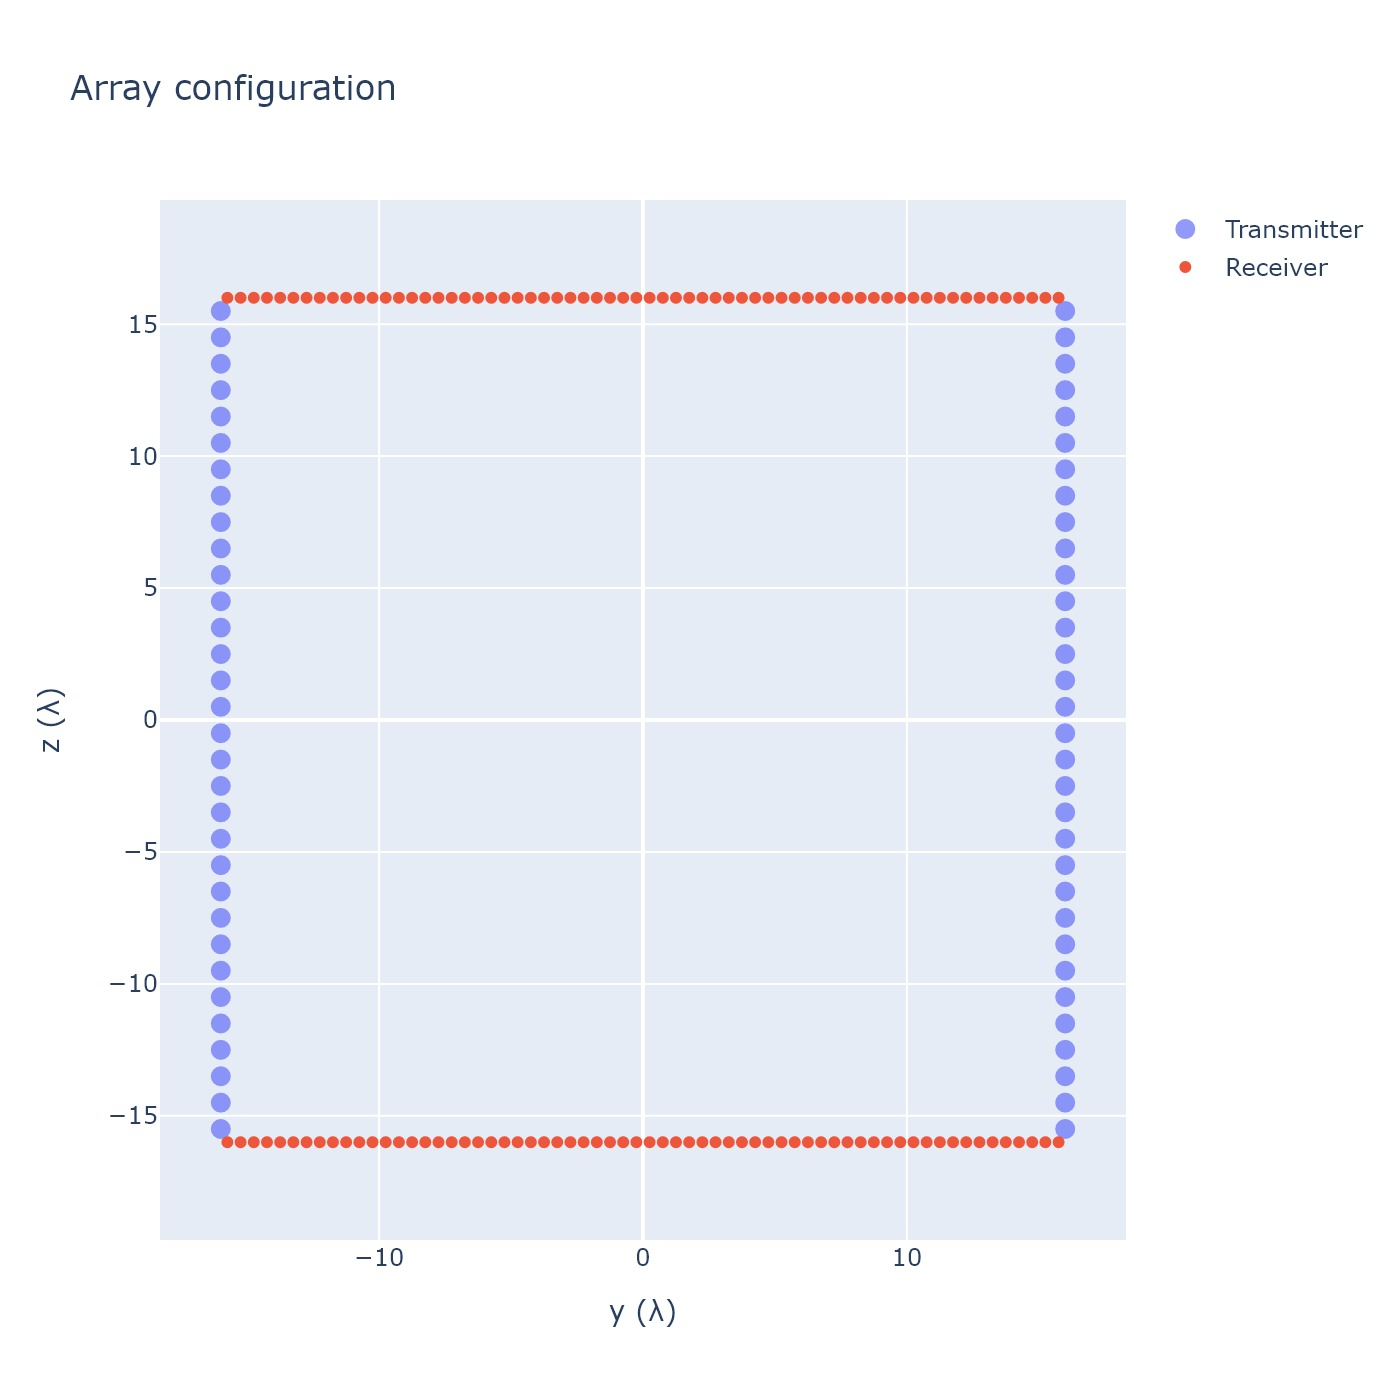

In [3]:
import plotly.graph_objs as go
from IPython.display import Image

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=radar.transmitter.locations[:, 1]/wavelength,
               y=radar.transmitter.locations[:, 2]/wavelength,
               mode='markers',
               name='Transmitter',
               opacity=0.7,
               marker=dict(size=10)))

fig.add_trace(
    go.Scatter(x=radar.receiver.locations[:, 1]/wavelength,
               y=radar.receiver.locations[:, 2]/wavelength,
               mode='markers',
               opacity=1,
               name='Receiver'))

fig.update_layout(
    title='Array configuration',
    height=700,
    xaxis=dict(title='y (λ)'),
    yaxis=dict(title='z (λ)',
               scaleanchor="x",
               scaleratio=1),
)

# fig.show()
Image(fig.to_image(format="jpg", scale=2))


## Target model

The target model is with `.stl`. It can be imported by using `meshio` module.

This is a half ring target with 2 m outer radius and 1 m inner radius.

In [4]:
target_1 = {
    'model': '../models/half_ring.stl',
    'location': (20, 0, 0),
    'speed': (0, 0, 0),
    'rotation': (0, 0, 0)
}

ball_1 = {
    'model': '../models/ball_1m.stl',
    'location': (20, -1, -1),
    'speed': (0, 0, 0),
    'rotation': (0, 0, 0)
}

ball_2 = {
    'model': '../models/ball_1m.stl',
    'location': (20, 1, -1),
    'speed': (0, 0, 0),
    'rotation': (0, 0, 0)
}

targets = [target_1, ball_1, ball_2]


Plot the 3D mesh of the half ring

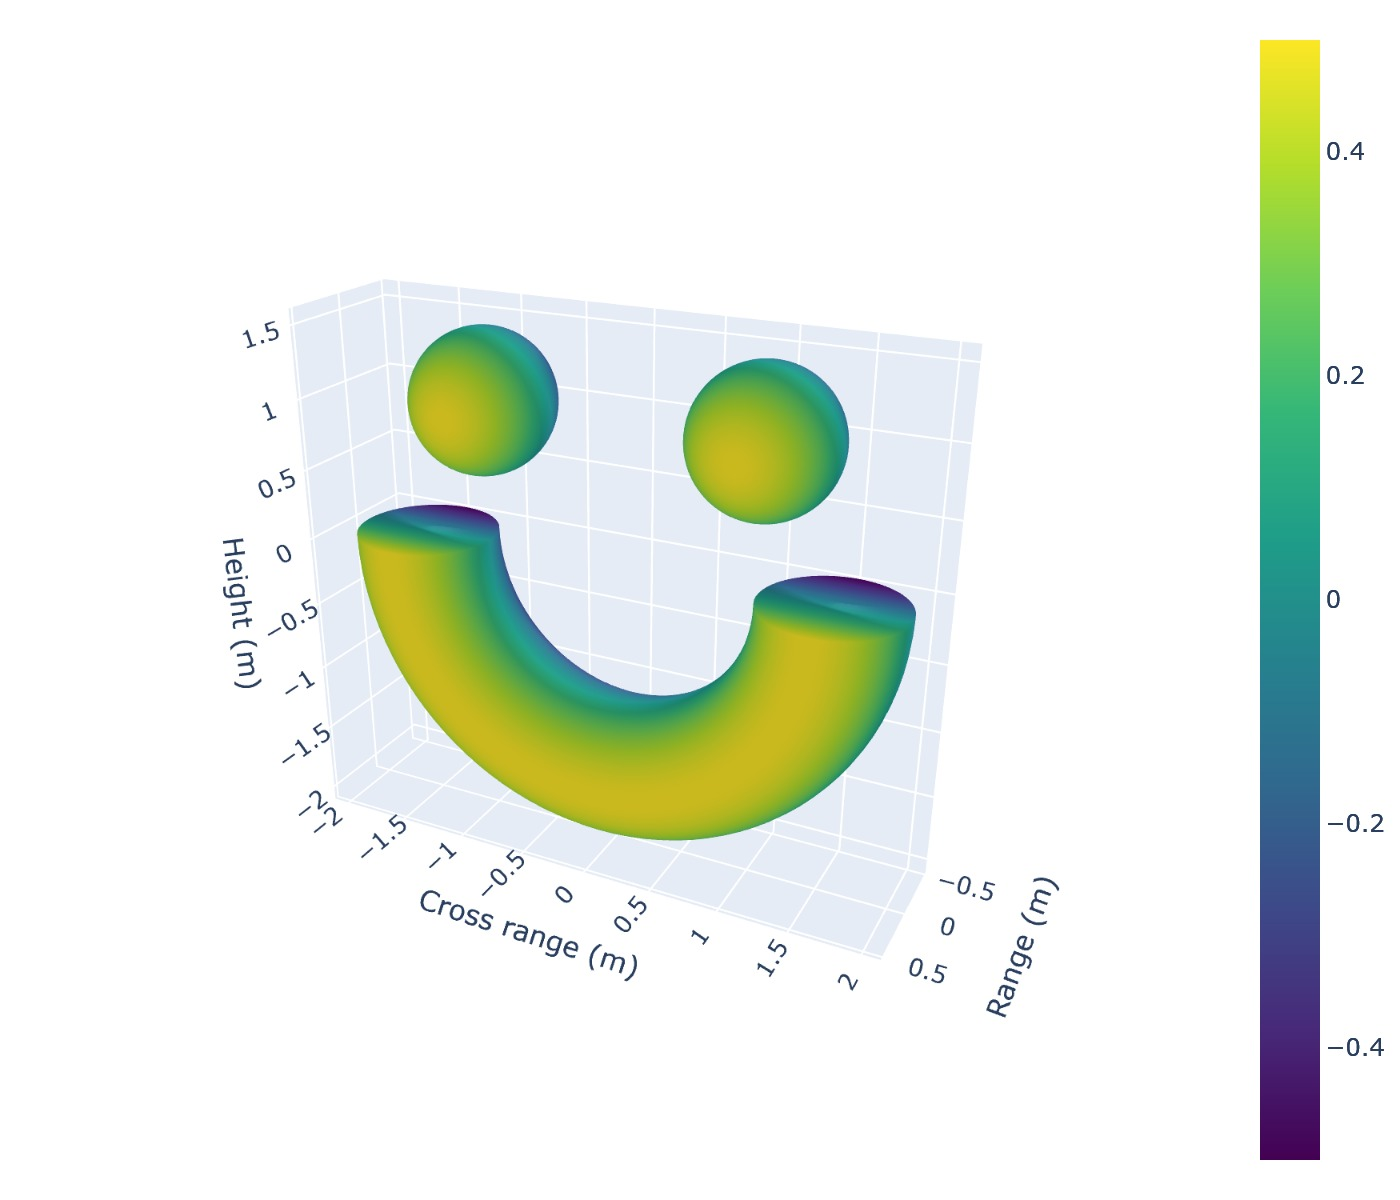

In [5]:
import meshio


fig = go.Figure()
mesh_data = meshio.read('../models/half_ring.stl')
fig.add_trace(go.Mesh3d(x=mesh_data.points[:, 0],
                        y=mesh_data.points[:, 1],
                        z=-mesh_data.points[:, 2],
                        i=mesh_data.cells[0].data[:, 0],
                        j=mesh_data.cells[0].data[:, 1],
                        k=mesh_data.cells[0].data[:, 2],
                        intensity=mesh_data.points[:, 0],
                        colorscale='Viridis'
                        ))
mesh_data = meshio.read('../models/ball_1m.stl')
fig.add_trace(go.Mesh3d(x=mesh_data.points[:, 0],
                        y=mesh_data.points[:, 1]-1,
                        z=-mesh_data.points[:, 2]+1,
                        i=mesh_data.cells[0].data[:, 0],
                        j=mesh_data.cells[0].data[:, 1],
                        k=mesh_data.cells[0].data[:, 2],
                        intensity=mesh_data.points[:, 0],
                        colorscale='Viridis'
                        ))

fig.add_trace(go.Mesh3d(x=mesh_data.points[:, 0],
                        y=mesh_data.points[:, 1]+1,
                        z=-mesh_data.points[:, 2]+1,
                        i=mesh_data.cells[0].data[:, 0],
                        j=mesh_data.cells[0].data[:, 1],
                        k=mesh_data.cells[0].data[:, 2],
                        intensity=mesh_data.points[:, 0],
                        colorscale='Viridis'
                        ))
camera = dict(
    up=dict(x=0, y=0, z=-1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=3, y=1.5, z=1.5)
)
fig.update_layout(
    height=600,
    scene=dict(
        xaxis=dict(title='Range (m)'),
        yaxis=dict(title='Cross range (m)'),
        zaxis=dict(title='Height (m)'),
        aspectmode='data',
        camera=camera,
    ),
    margin=dict(l=10, r=0, b=10, t=10),
)

# fig.show()
Image(fig.to_image(format="jpg", scale=2))


## Raytracing

In [6]:
from radarsimpy.rt import scene
import time

tic = time.time()
data = scene(radar, targets, density=0.3, noise=True)

baseband = data['baseband']
toc = time.time()

print('Exec time:', toc-tic, 's')


Exec time: 1179.5803697109222 s


## Radar signal processing

### Range processing and thresholding

In [12]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.chebwin(radar.samples_per_pulse, at=80)
range_profile = proc.range_fft(baseband, rwin=range_window)

range_profile_avg = np.mean(np.abs(range_profile[:, :, :]), axis=0)
cfar = proc.cfar_os_1d(
    range_profile_avg[0, :], guard=0, trailing=10, k=14, pfa=1e-4, offset=1.1, detector='linear')


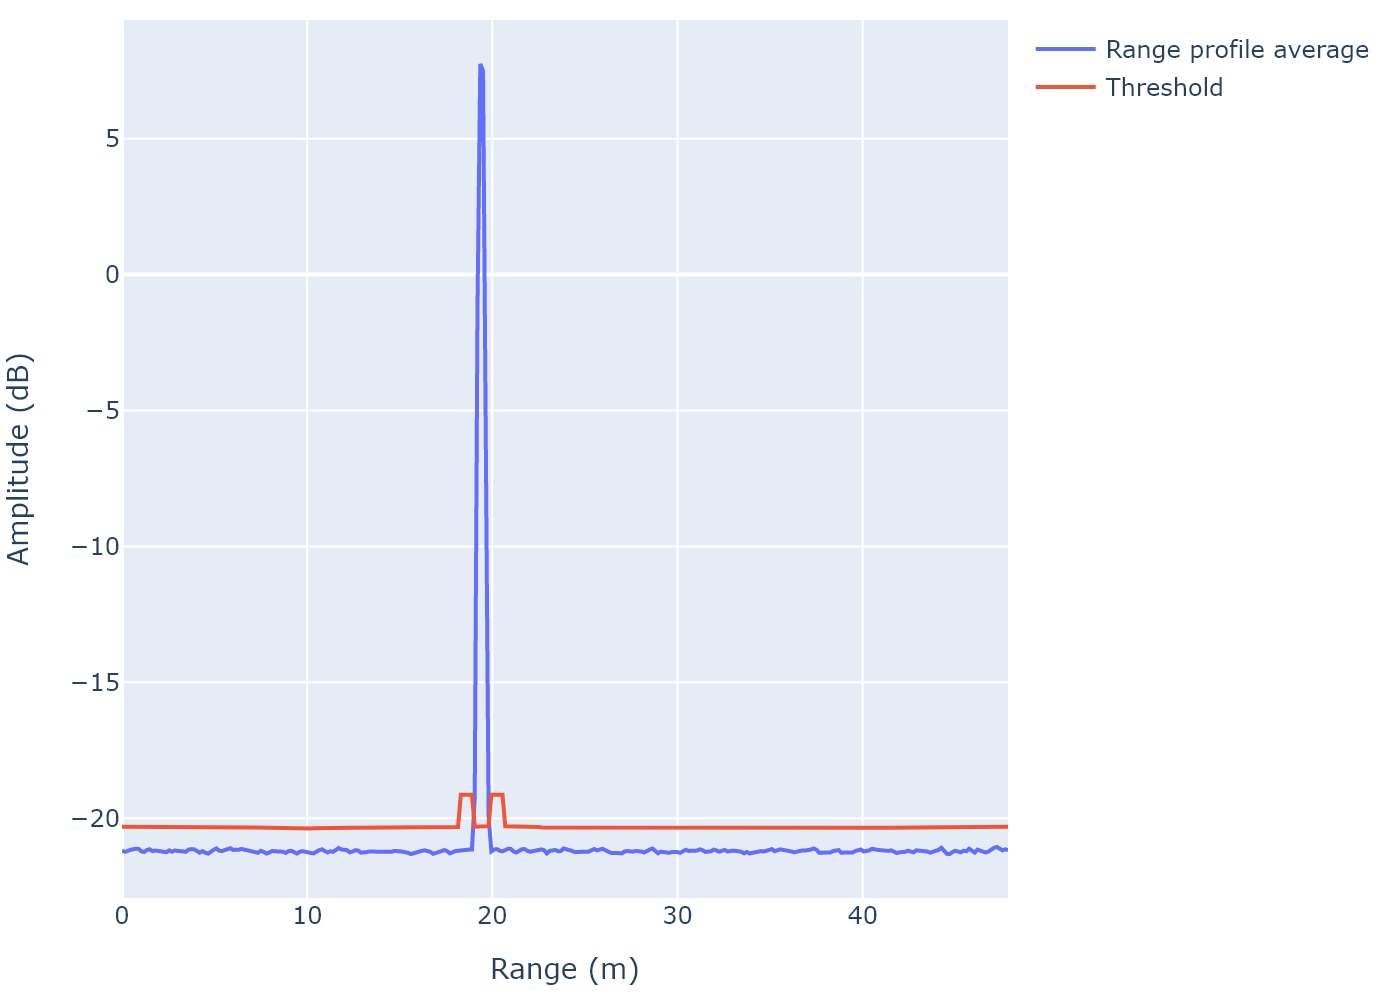

In [14]:
max_range = (3e8 * radar.receiver.fs *
             radar.transmitter.pulse_length /
             radar.transmitter.bandwidth / 2)
range_axis = np.flip(np.linspace(
    0, max_range, radar.samples_per_pulse, endpoint=False))

fig = go.Figure()

fig.add_trace(go.Scatter(x=range_axis,
                         y=20*np.log10(range_profile_avg[0, :]),
                         name='Range profile average')
              )
fig.add_trace(go.Scatter(x=range_axis,
                         y=20*np.log10(cfar),
                         name='Threshold')
              )

fig.update_layout(
    yaxis=dict(title='Amplitude (dB)'),
    xaxis=dict(title='Range (m)'),
    margin=dict(l=10, r=10, b=10, t=10),
)

# fig.show()
Image(fig.to_image(format="jpg", scale=2))


In [15]:
from scipy import fft
from scipy import signal

win_el = signal.chebwin(64, at=50)
win_az = signal.chebwin(128, at=50)

win_mat = np.tile(win_el[..., np.newaxis], (1, N_rx)) * \
    np.tile(win_az[np.newaxis, ...], (N_tx, 1))

# det_idx = [np.argmax(range_profile_avg)]

det_idx = np.where(range_profile_avg > cfar)[1]

spec = np.zeros((1024, 1024))
for peak_idx in range(0, len(det_idx)):
    raw_bv = range_profile[:, 0, det_idx[peak_idx]]

    bv = np.zeros((N_tx, N_rx), dtype=np.complex128)

    half_tx = int(N_tx/2)
    half_rx = int(N_rx/2)
    for t_idx in range(0, half_tx):
        bv[t_idx, 0:half_rx] = raw_bv[t_idx*N_rx:(t_idx*N_rx+half_rx)]
        bv[t_idx, half_rx:] = raw_bv[int(
            (t_idx+half_tx)*N_rx):((t_idx+half_tx)*N_rx+half_rx)]

        bv[t_idx+half_tx,
            0:half_rx] = raw_bv[(t_idx*N_rx+half_rx):(t_idx*N_rx+N_rx)]
        bv[t_idx+half_tx,
            half_rx:] = raw_bv[int((t_idx+half_tx)*N_rx+half_rx):int((t_idx+half_tx)*N_rx+N_rx)]
    spec = np.maximum(spec, np.abs(fft.fftshift(
        fft.fft2(bv[:, :]*win_mat, s=[1024, 1024]))))
    # spec = np.abs(fft.fftshift(fft.fft2(bv[:, :]*win_mat)))


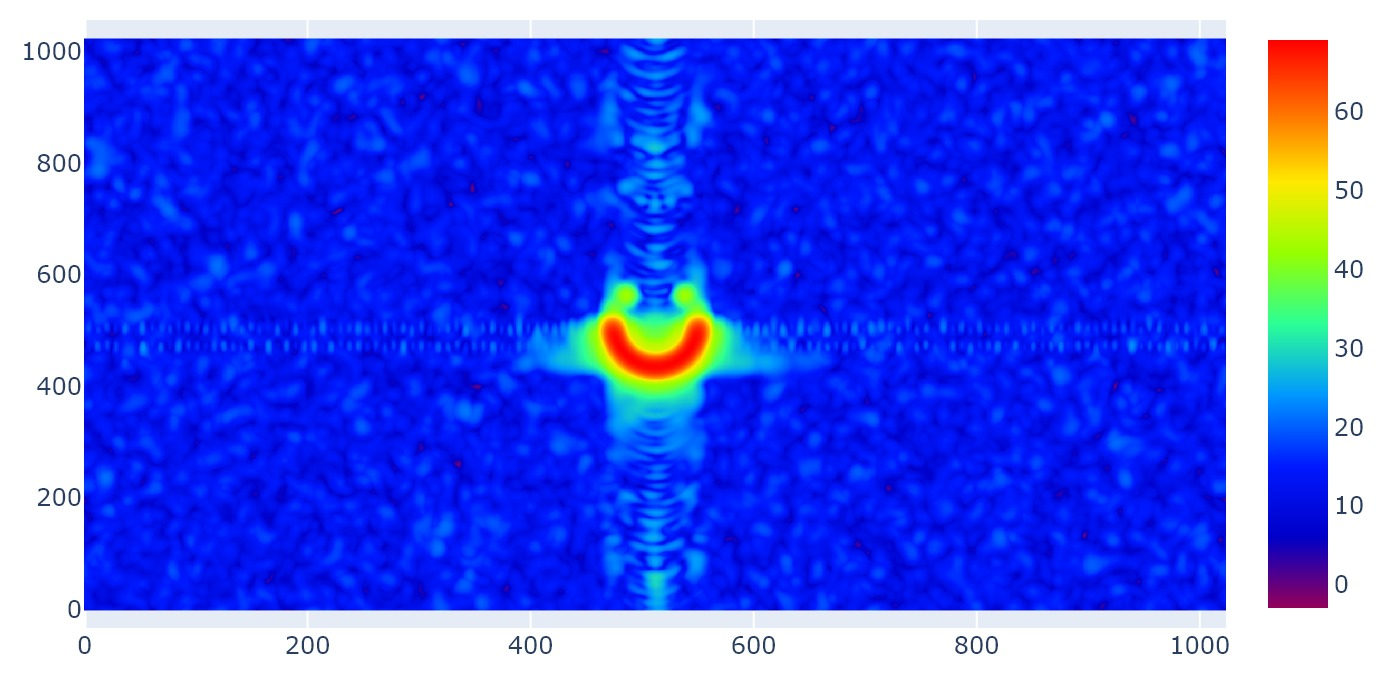

In [16]:
fig = go.Figure()

fig.add_trace(go.Heatmap(
    z=20 * np.log10(spec), colorscale='Rainbow'))

fig.update_layout(
    height=340,
    xaxis=dict(),
    yaxis=dict(scaleanchor="x",
               scaleratio=0.5),
    margin=dict(l=10, r=10, b=10, t=10),
)

# fig.show()
Image(fig.to_image(format="jpg", scale=2))
